# Problema de Busca - Super Mario Bros
## Projeto da disciplina **SCC0230 - Inteligência Artificial**
### Assunto: Busca Informada e Busca Cega

## Membros

* Alexandre Eduardo de Souza Jesus - alexandre_souza@usp.br - 12559506

* Arthur Santorum Lorenzetto - arts.lorenzetto@usp.br - 12559465

* Eduardo Zaffari Monteiro - eduardozaffarimonteiro@usp.br - 12559490

* Gustavo Silva de Oliveira - gustavo.oliveira03@usp.br - 12567231 (Vice-Líder)

* Lucas Ivars Cadima Ciziks - luciziks@usp.br - 125599472 (Líder)

* Pedro Henrique de Freitas Maçonetto - pedromaconetto@usp.br - 12675419

* Vitor Okubo Ianella - vitorok.03@gmail.com - 12559451

## Introdução

No mundo real, há uma infinidade de questões que podem ser classificadas como **Problemas de Busca**, tais quais a logística de entrega de um produto, o melhor caminho entre duas estações de trem e até mesmo na resolução de jogos. Nesse contexto, é importante compreender as diferentes abordagens e aplicações envolta desses problemas no estudo da Inteligência Artificial. Resumidamente, uma **Busca Cega** ou Não Informada é uma abordagem que não utiliza nenhuma informação adicional além do que definido no problema original, tentando exaustivamente até encontrar a solução ou falhar. Já a **Busca Informada** utiliza uma heurística, algum conhecimento ou informação que auxila nas decisões e torna a busca mais eficiente. Assim, o presente projeto possui como objetivo implementar e comparar os resultados entre algoritmos de Busca Cega e Busca Informada para um mesma problemática em investigação: **O Resgate da Princesa Peach**.

Nesse problema, baseado no mundo fantástico de [Super Mario Bros](https://pt.wikipedia.org/wiki/Super_Mario_Bros.#Enredo), o encanador Mario precisa resgatar a Princesa Peach, raptada pelo vilão Bowser, viajando até sua ardente fortaleza. Em seu caminho, Mario deve enfrentar e derrotar os inimigos que tentarão impedir sua passagem até o castelo. Para isso, Mario precisa comer um **Cogumelo** e assim derrotá-los para finalmente chegar ao castelo e derrotar Bowser. Abstraindo para um problema de busca, Mario começa em um ponto do labirinto (estado inicial) e, antes de chegar ao castelo (estado final), ele precisa comer o **cogumelo** (primeira condição de parada) para derrotar todos os **Goombas** (obstáculos). É importante destacar que antes de comer o cogumelo, os Goombas não permitirão a passagem de Mario.

## Modelagem do Problema

Detalhando o problema apresentado:

* **Estados**: Configuração corrente da matriz do labirinto;

* **Operadores**: Mover o Mario uma casa em 4 direções possíveis (Leste, Oeste, Norte ou Sul);

* **Movimentos Válidos**: Não parede / Não Goomba antes do Cogumelo / Goomba após o Cogumelo / Cogumelo / Cogumelo Comido;

* **Configuração Final**: O Cogumelo foi comido, todos os Goombas foram derrotados e o Mario chegou ao Castelo.

* **Custo do Caminho**: Cada movimento tem um custo unitário.

Em nosso processamento, a matriz de entrada contendo o labirinto será um arquivo csv, como a do exemplo utilizado. Visualmente, ela será representada da seguinte forma:

![Exemplo do Labirinto](media/exemplo.png)

em que:
* 0 representa uma parede;
* 1 é um corredor;
* 2 é um Goomba/inimigo;
* 3 representa o ponto inicial do Mario;
* 4 é o castelo do Bowser (Ponto Final);
* 5 é o cogumelo que fornece poderes ao Mario.


## Busca Não Informada

A Busca Não Informada escolhida para resolver nosso problema foi a **Busca Cega em Profundidade** (Depth-First). Isso se deve à economia de memória proporcionada quando em comparação à busca em largura (Breadth-First). A ordem de expansão definida em nosso algoritmo foi Leste, Oeste, Norte e Sul. Para computar a matriz de entrada, transformamos-na em um **Grafo**, onde mapeamos todas as possíveis extensões/caminhos de cada nó (coordenada da matriz). Isso, em conjunto com a estrutura de dados **Pilha**, auxilia a manipulação dos dados e o *backtracking* na busca.

Uma adaptação necessária para nosso problema foi o reinício das posições visitadas (exceto pela posição atual) após o Mario consumir um cogumelo ou derrotar um Goomba.

In [1]:
import pandas as pd
import numpy as np
from collections import deque

In [2]:
# Capturando pontos especiais
def important_points(maze):    
    start_point = np.where(maze == 3)
    start = (int(start_point[0]), int(start_point[1]))
    
    end_point = np.where(maze == 4)
    end = (int(end_point[0]),int(end_point[1]))
    
    mushroom_point = np.where(maze == 5)
    mushroom = (int(mushroom_point[0]),int(mushroom_point[1]))
    
    goomba_points = np.where(maze == 2)
    goombas_x = goomba_points[0]
    goombas_y = goomba_points[1]
    goombas = []
    for i in range(len(goombas_x)):
        goombas.append((int(goombas_x[i]), int(goombas_y[i])))

        # Sem cogumelo, Goomba é interpretado como uma parede
        maze[int(goombas_x[i])][int(goombas_y[i])] = 0
    
    maze[start_point] = 1
    maze[end_point] = 1
    
    return start, end, mushroom, goombas

In [3]:
# Função responsável por transformar labirinto em grafo de pontos
def maze2graph(maze):
    colunas = len(maze)
    linhas = len(maze[0])
    grafo = {(i, j): [] for j in range(linhas) for i in range(colunas) if maze[i][j]}
    
    for linha, coluna in grafo.keys():
        
        if not(linha < colunas - 1 and not maze[linha + 1][coluna]):
            grafo[(linha, coluna)].append(("S", (linha + 1, coluna)))
            grafo[(linha + 1, coluna)].append(("N", (linha, coluna)))

        if not(coluna < linhas - 1 and not maze[linha][coluna + 1]):
            grafo[(linha, coluna)].append(("L", (linha, coluna + 1)))
            grafo[(linha, coluna + 1)].append(("O", (linha, coluna)))

    return grafo

In [4]:
# Implementação da Busca Cega em Profundidade
def depth_first_algorithm(maze, start, end):
    pilha = deque([("", start)])
    visitado = set()
    graph = maze2graph(maze)
    
    while pilha:
        caminho, atual = pilha.pop()
        if atual == end:
            return caminho

        if atual in visitado:
            continue

        visitado.add(atual)
        for direcao, vizinho in graph[atual]:
            pilha.append((caminho + direcao, vizinho))
            
    return "Sem caminho!"

In [5]:
# Insere o caminho encontrado em uma cópia matriz do labirinto
def visualize_path(maze, path, start):
    caminho_atual = start
    
    for value in list(path):

        if value == 'L':
            maze[caminho_atual[0]][caminho_atual[1]] = '→'
            caminho_atual = (caminho_atual[0], caminho_atual[1] + 1)

        elif value == 'O':
            maze[caminho_atual[0]][caminho_atual[1]] = '←'
            caminho_atual = (caminho_atual[0], caminho_atual[1] - 1)

        elif value == 'N':
            maze[caminho_atual[0]][caminho_atual[1]] = '↑'
            caminho_atual = (caminho_atual[0] - 1, caminho_atual[1])

        elif value == 'S':
            maze[caminho_atual[0]][caminho_atual[1]] = '↓'
            caminho_atual = (caminho_atual[0] + 1, caminho_atual[1])
        
    return maze

In [6]:
# Função responsável por copiar o labirinto
def copy_maze(maze, start, end, mushroom, goombas):
    maze_copy = maze.copy().tolist()
    maze_copy[start[0]][start[1]] = 'I'
    maze_copy[end[0]][end[1]] = 'F'
    maze_copy[mushroom[0]][mushroom[1]] = 'C'
    for goomba in goombas:
        maze_copy[goomba[0]][goomba[1]] = 'G'
    maze_copy = [[str(ele) for ele in sub] for sub in maze_copy]
    
    return maze_copy

In [7]:
# Função responsável por solucionar o labirinto (Depth-First)
def solved_maze_depth(maze):
    # Recuperando pontos especiais
    start, end, mushroom, goombas = important_points(maze)

    # Encontrando o caminho entre o ponto inicial e o cogumelo (primeira condição de parada)
    start_to_mushroom = depth_first_algorithm(maze, start, mushroom)

    # Agora o Mario tem poder para derrotar o Goomba
    for goomba in goombas:
        maze[goomba[0]][goomba[1]] = 1

    # Encontrando o caminho entre o cogumelo e o goomba
    mushroom_to_goomba_paths = []
    start_goomba = mushroom
    goombas.reverse()
    for next_goomba in goombas:
        mushroom_to_goomba_paths.append(depth_first_algorithm(maze, start_goomba, next_goomba))
        start_goomba = next_goomba
        
    # Encontrando o caminho entre o goomba e o ponto final
    goomba_to_end = depth_first_algorithm(maze, start_goomba, end)

    # Visualizando caminhos
    start_mushroom_matrix = visualize_path(copy_maze(maze, start, end, mushroom, goombas), start_to_mushroom, start)

    mushroom_goomba_matrixes = []
    start_goomba = mushroom
    for i in range(len(goombas)):
        mushroom_goomba_matrixes.append(visualize_path(copy_maze(maze, start, end, mushroom, goombas), mushroom_to_goomba_paths[i], start_goomba))
        start_goomba = goombas[i]
        
    goomba_end_matrix = visualize_path(copy_maze(maze, start, end, mushroom, goombas), goomba_to_end, start_goomba)

    return start_mushroom_matrix, *mushroom_goomba_matrixes, goomba_end_matrix

In [8]:
# Lendo Labirinto do arquivo CSV
maze_csv = pd.read_csv('mazes/maze_expert.csv', header=None)

# Transformando Labirinto em matriz completa
maze = maze_csv.to_numpy()

# Resolvendo o labirinto
answer_maze_depth = solved_maze_depth(maze)

# Visualizando resposta
for map in answer_maze_depth:
    for line in map:
        print(line)
    print('\n')

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '↓', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', 'G', '0', '0', '0', '0', '0']
['0', '→', '→', '↓', '0', '0', '0', '0', '0', '0', '1', '1', '0', '0', '1', '0', '0', '0', '0', '0']
['0', '0', '0', '↓', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0']
['0', '0', '0', '↓', '0', '0', '0', '0', 'G', '0', '0', '1', '0', '0', '1', '0', '0', '0', '0', '0']
['0', '0', '0', '↓', '0', '0', '→', '→', '↓', '1', '1', '1', '1', '1', '1', '1', '1', 'G', '0', '0']
['0', '1', '1', '↓', '0', '0', '↑', '0', '↓', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '0', '0', '↓', '0', '0', '↑', '0', '↓', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '0', '0', '→', '→', '→', '↑', '0', '↓', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '0', '0', '1', '0', '0', '0', '0', '↓', '0', '0', '0', '0', '0', '1', '1', '1', '0', 

## Busca Informada

A escolha do **algoritmo A*** para a resolução do problema em questão se deve ao fato dele garantir encontrar o caminho ótimo dentro do labirinto, através do uso de *backtracking*. Isso porque o algoritmo se caracteriza por sempre expandir o nó aparentemente mais promissor através do uso de uma heurística, o que, em contrapartida, torna-o mais custoso em processamento.

A heurística h(n) utilizada para nosso problema foi a **distância de Manhattan** entre a posição atual do Mario dentro do labirinto e o castelo do Bowser (posição final). Tal escolha se justifica, principalmente, devido ao fato do problema limitar sua operação em apenas 4 direções (Norte, Sul, Leste e Oeste). Essa heurística é **admissível** para nosso problema, pois a distância calculada nunca será maior do que a "real", uma vez que também é calculada apenas nas 4 direções e similar à de Manhattan.

In [9]:
# Definindo heurística baseada na distância de Manhattan
def manhattan_distance(ponto1, ponto2):
    x_1, y_1 = ponto1
    x_2, y_2 = ponto2
    return np.abs(x_1 - x_2) + np.abs(y_1 - y_2)

In [10]:
# Implementação da Busca Heurística A*
def a_search_algorithm(ponto_inicial, ponto_final, grafo):
    caminhos_possiveis = [[[ponto_inicial], manhattan_distance(ponto_inicial,ponto_final)]]
    atual = ponto_inicial
    caminho_errado = []
    
    while atual != ponto_final:
        caminho = caminhos_possiveis[0][0]
        visitados = len(caminho)

        if len(grafo[caminho[-1]]) > 0:
            for vizinho in grafo[caminho[-1]]:
                direcao, coord = vizinho
                
                if coord not in caminho and coord not in caminho_errado:
                    novo_caminho = caminho.copy()
                    novo_caminho.append(coord)
                    caminhos_possiveis.append([novo_caminho, manhattan_distance(coord, ponto_final) + visitados])
                    
            caminhos_possiveis.pop(0)
            caminhos_possiveis.sort(key=lambda x: x[1])
            atual = caminhos_possiveis[0][0][-1]
        else:
            caminho_errado.append(caminho[-1])
    
    return caminhos_possiveis[0][0]

In [11]:
# Calculando caminho para matar goombas/inimigos
def defeat_goombas(goombas, musshroom, maze):
    tam_menor_caminho = []
    tam_caminho_percorrido = []
    grafo = maze2graph(maze)
    
    goombas.sort(key=lambda x: manhattan_distance(x, musshroom))
    caminho = [a_search_algorithm(musshroom, goombas[0], grafo)]

    for i in range(len(goombas) - 1):
        goomba_atual = goombas.pop(0)
        goombas.sort(key=lambda x: manhattan_distance(x, goomba_atual))
        caminho.append(a_search_algorithm(goomba_atual, goombas[0], grafo))
        
    return caminho, goombas[0]

In [12]:
# Encontra pontos especiais no labirinto dado seu valor
def find_points(valor, maze):
    pontos = []
    for i in range(len(maze)):
        for j in range(len(maze[0])):
            if maze[i][j] == valor:
                pontos.append((i, j))
    return pontos
    
# Convertendo array do numpy para uma lista
def convert_numpy_list(num):
    lis = []
    for i in num:
        lis2 = []
        for j in i:
            lis2.append(str(j))
        lis.append(lis2)
    return lis

# Visualizar as matrizes resposta
def visualize_path_a_search(caminho, maze):
    direcoes = []
    anterior = caminho[0]
    maze = convert_numpy_list(maze)

    for pos in caminho[1:]:
        y_ant, x_ant = anterior
        y_pos, x_pos = pos

        if x_pos - x_ant == 1:
            maze[y_ant][x_ant] = '→'

        elif x_pos - x_ant == -1:
            maze[y_ant][x_ant] = '←'

        elif y_pos - y_ant == 1:
            maze[y_ant][x_ant] = '↓'

        elif y_pos - y_ant == -1:
            maze[y_ant][x_ant] = '↑'

        anterior = pos
        
    return maze

In [13]:
# Resolve o labirinto através do A*
def solved_maze_a_search(maze):
    maze_copy = maze.copy()

    # Recuperando pontos especiais
    start = find_points(3, maze_copy)[0]
    end = find_points(4, maze_copy)[0]
    mushroom = find_points(5, maze_copy)[0]
    goombas = find_points(2, maze_copy)

    grafo = maze2graph(maze_copy)
    
    # Calculando caminho do ponto inicial ao cogumelo
    start_mushroom = a_search_algorithm(start, mushroom, grafo)

    # Agora os goombas podem ser derrotados
    for i in goombas:
        maze_copy[i[0]][i[1]] = 1
    
    # Calculando caminho do cogumelo até os goombas
    mushroom_goomba, ultimo_goomba = defeat_goombas(goombas, mushroom, maze_copy)

    # Calculando caminho do último goomba até o castelo
    goomba_end = a_search_algorithm(ultimo_goomba, end, grafo)
    
    # Visualizando caminhos calculados
    start_mushroom_map = visualize_path_a_search(start_mushroom, maze_copy)
    
    goomba_maps = []
    for goomba in mushroom_goomba:
        goomba_maps.append(visualize_path_a_search(goomba, maze_copy))
    
    castle_map = visualize_path_a_search(goomba_end, maze_copy)

    return [start_mushroom_map] + goomba_maps + [castle_map]
    

In [14]:
# Lendo arquivo referente ao arquivo csv
maze_easy = pd.read_csv('mazes/maze_easy.csv', header=None).values

# Resolvendo o labirinto
maze_answer = solved_maze_a_search(maze_easy)

# Visualizando resposta
for map in maze_answer:
    for line in map:
        print(line)
    print('\n')

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '↓', '←', '←', '←', '←', '1', '1', '1', '0']
['0', '↓', '0', '1', '0', '1', '0', '0', '4', '0']
['0', '↓', '0', '1', '0', '1', '0', '0', '1', '0']
['0', '↓', '0', '0', '0', '1', '0', '1', '0', '0']
['0', '↓', '0', '0', '0', '0', '0', '0', '5', '0']
['0', '→', '→', '→', '→', '→', '→', '→', '↑', '0']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '→', '→', '↓', '1', '3', '1', '1', '1', '0']
['0', '↑', '0', '↓', '0', '1', '0', '0', '4', '0']
['0', '↑', '0', '1', '0', '1', '0', '0', '1', '0']
['0', '↑', '0', '0', '0', '1', '0', '1', '0', '0']
['0', '↑', '0', '0', '0', '0', '0', '0', '↓', '0']
['0', '↑', '←', '←', '←', '←', '←', '←', '←', '0']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']
['0', '1', '1', '→', '→', '→', '→', '→', '↓', '0']
['0', '1', '0', '↑', '0', '1', '0', '0', '4', '0']
['0', '1', '0', '↑', '0', '

## Conclusão

Comparemos, por fim, os algoritmos de Busca Cega em Profundidade e A*.

O algoritmo por Busca Cega em Profundidade (Busca Não Informada) por mais que simples, uma vez que não possui nenhuma informação adicional além de sua definição, o algoritmo não garante encontrar a solução ótima. Caracterizando-se, assim, por começar num nó raiz e explorar tanto quanto possível cada um dos seus ramos, antes de retroceder (backtracking).

Já o algoritmo A* (Busca Informada), ao usar uma heurística admissível, garante sempre encontrar o caminho mais curto para o objetivo. Por ser uma busca que utiliza um conhecimento específico do problema para dar uma pista para a solução, essa estratégia de busca impede que o algoritmo tenha problemas com o objetivo e com a direção da solução.

Dessa forma, com uma heurística consistente, A* faz a menor quantidade de expansões necessárias para provar que a solução é ótima.

Fazendo uma avaliação e interpretação dos resultados:

![Resultados](media/resultados.png)
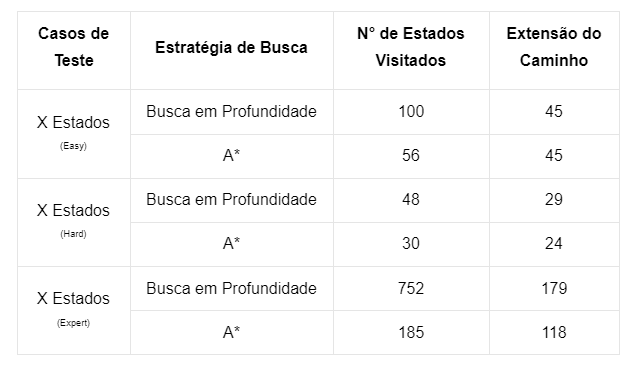

## Referências


* BRATKO, I. Prolog Programming for Artificial Intelligence . Mitchell, T. Machine Learning , McGraw Hill, 1997;

* RUSSEL, S.; NORVIG, P. Artificial Intelligence : A Modern Approach. Prentice Hall; 3 edition (December 11, 2009).

* DIFFERENCE between Informed and Uninformed Search in AI. [S. l.], 23 ago. 2022. Disponível em: https://www.geeksforgeeks.org/difference-between-informed-and-uninformed-search-in-ai/?ref=lbp. Acesso em: 15 out. 2022.

* E. SZABO, Fred. Manhattan Distance. [S. l.], 2015. Disponível em: https://www.sciencedirect.com/topics/mathematics/manhattan-distance. Acesso em: 15 out. 2022.

* DIFFERENCE between BFS and DFS. [S. l.], 12 set. 2022. Disponível em: https://www.geeksforgeeks.org/difference-between-bfs-and-dfs/?ref=lbp. Acesso em: 15 out. 2022.

* INTRODUCTION to A*. [S. l.], 2009. Disponível em: http://theory.stanford.edu/~amitp/GameProgramming/AStarComparison.html. Acesso em: 15 out. 2022.
